In [218]:
import pandas as pd
import numpy as np
import glob
import openpyxl
import pyxlsb
import os
import datetime
import re
import math

#invoiceデータの格納先パスの指定
#os.chdir("./Desktop/invoice")
os.getcwd()

'c:\\Users\\owner\\Desktop\\invoice'

In [219]:
#拡張子.xlsxへのファイルパスを取得し、path_strに格納。
path_str = "*.xlsx"

#globライブラリのglobメソッドでファイルをリストで取得し、pathsに格納。
paths = glob.glob(path_str)

#xlsxファイルのリストを表示。
print(paths)
#xlsxファイルの数を確認。
print(len(paths))





df = pd.DataFrame(columns=["請求年月","店舗名","M(数量)","L(数量)","Ex(数量)","M(単価)","L(単価)","Ex(単価)","合計売上(税別)","収益性"])


#4406個のxlsxファイルを順に取り出す。
for i in range(4406):
  # 空の辞書を作成
  wb_data = {}
  # ブックを開く
  wb = openpyxl.load_workbook(paths[i],data_only=True) #ファイルのリストからopenpyxlライブラリのload_workbook関数を用いて、ブックを開く。

  #シート名が"invoice"の場合。※今回シート名がinvoice、請求書、Sheet1(←xlsbファイルをxlsxに変換後のシート名がSheet1)の3種類。
  if "invoice" in wb.sheetnames:
    sheet = wb["invoice"]
 
    #請求年月の取得。
    # 結合されたセルの左上のセルの座標を指定
    billing_date = "H1" 
    # 結合セル内の文字列を取得
    billing_date1 = sheet[billing_date].value 
    # 文字列から日付部分を抽出
    if "請求日" in billing_date1:
      text = billing_date1

# 正規表現を使用して日付部分を抽出
      match = re.search(r'\d{4}-\d{2}-\d{2}', text)
      match1 =  re.search(r'\d{4}/\d{2}/\d{2}', text)
      if match:
         extracted_date = match.group()  # マッチした日付部分を取得
         wb_data["請求年月"] = extracted_date
      elif match1:
        extracted_date = match1.group()  # マッチした日付部分を取得
        # "YYYY/MM/DD" から "YYYY-MM-DD" に変更
        formatted_date = extracted_date.replace("/", "-")
        wb_data["請求年月"] = formatted_date


    

    #店舗名の取得
    # 結合されたセルの左上のセルの座標を指定
    merged_cell_coordinate1 = "B4" 
    merged_cell_coordinate2 = "B6" 
    # 結合セル内の文字列を取得
    merged_cell_value1 = sheet[merged_cell_coordinate1].value
    merged_cell_value2 = sheet[merged_cell_coordinate2].value
    # 必要な部分を抽出
    merged_cell_value3 = merged_cell_value1 + " " + merged_cell_value2
    wb_data["店舗名"] = merged_cell_value3
    #商品の数量を取得。
    wb_data["M(数量)"] = sheet["F17"].value
    wb_data["L(数量)"] = sheet["F18"].value
    if "F19" not in sheet or sheet["F19"].value is None or math.isnan(sheet["F19"].value):
      wb_data["Ex(数量)"] = 0
    else:
      wb_data["Ex(数量)"] = sheet["F19"].value
    #商品の単価を取得。
    wb_data["M(単価)"] = sheet["H17"].value
    wb_data["L(単価)"] = sheet["H18"].value
    if sheet["H19"].value is None or math.isnan(sheet["H19"].value):
      wb_data["Ex(単価)"] = 0
    else:
      wb_data["Ex(単価)"] = sheet["H19"].value

    #シートinvoiceにはラグジュアリシャンプーの項目が含まれていないので、その変数は割愛。
    mens_shampoo_counts = sheet["F17"].value
    mens_shampoo_price = sheet["H17"].value
    womens_shampoo_counts = sheet["F18"].value
    womens_shampoo_price = sheet["H18"].value
    mens_amount = mens_shampoo_counts * mens_shampoo_price
    womens_amount = womens_shampoo_counts * womens_shampoo_price
    #売上に消費税を含めないので、コメントアウト。
    #consumption_tax = (mens_amount + womens_amount) * 0.1
    total_amount = mens_amount + womens_amount 
    wb_data["合計売上(税別)"] = total_amount

    #収益性を求める。
    profitability =  (total_amount - ((mens_shampoo_counts + womens_shampoo_counts) * 800)) / total_amount
    wb_data["収益性"] = profitability

  #シート名が"請求書"の場合。
  elif "請求書" in wb.sheetnames:
    sheet = wb["請求書"]
    #請求年月の取得。
    # 結合されたセルの左上のセルの座標を指定
    billing_date = "G3" #G3はシリアル値あるいはfloat。
   # セルの値を取得
    billing_date1 = (sheet[billing_date].value)
    if type(billing_date1) == "float":
  # 文字列が"YYYY/MM/DD"形式かどうかをチェック
      if '/' in billing_date1:
      # "YYYY/MM/DD" から "YYYY-MM-DD" に変更
        formatted_date = billing_date1.replace("/", "-")
        wb_data["請求年月"] = formatted_date


# 任意のシリアル値を指定
    serial_value = billing_date1  

# シリアル値を日付に変換
    base_date = datetime.date(1900, 1, 1)
 
    if isinstance(billing_date1, (int, float)):  # シリアル値の場合
      try:
        # シリアル値を日付に変換
        date_obj = base_date + datetime.timedelta(days=int(billing_date1))
        formatted_date = date_obj.strftime('%Y-%m-%d')
        wb_data["請求年月"] = formatted_date
      except ValueError:
        # 例外が発生した場合、そのままの値を使用
        wb_data["請求年月"] = billing_date1
    elif isinstance(billing_date1, str):  # 文字列の場合
      try:
        # 日付文字列をdatetime型に変換
        date_obj = datetime.datetime.strptime(billing_date1, '%Y-%m-%d')
        formatted_date = date_obj.strftime('%Y-%m-%d')
        wb_data["請求年月"] = formatted_date
      except ValueError:
        # 例外が発生した場合、そのままの値を使用
        wb_data["請求年月"] = billing_date1
    else:     
      wb_data["請求年月"] = None  # その他の場合には None などを設定



    #店舗名の取得。
    # 結合されたセルの左上のセルの座標を指定
    merged_cell_coordinate = "A2" 
    # 結合セル内の文字列を取得
    merged_cell_value = sheet[merged_cell_coordinate].value

    wb_data["店舗名"] = merged_cell_value
    #商品の数量を取得。
    wb_data["M(数量)"] = sheet["D15"].value
    wb_data["L(数量)"] = sheet["D16"].value
    if sheet["D17"].value is None or math.isnan(sheet["D17"].value):
      wb_data["Ex(数量)"] = 0
    else:
      wb_data["Ex(数量)"] = sheet["D17"].value
    #商品の単価を取得。
    wb_data["M(単価)"] = sheet["F15"].value
    wb_data["L(単価)"] = sheet["F16"].value
    if sheet["F17"].value is None or math.isnan(sheet["F17"].value):
      wb_data["Ex(単価)"] = 0
    else:
      wb_data["Ex(単価)"] = sheet["F17"].value
    mens_shampoo_counts = sheet["D15"].value
    mens_shampoo_price = sheet["F15"].value
    womens_shampoo_counts = sheet["D16"].value
    womens_shampoo_price = sheet["F16"].value
    mens_amount = mens_shampoo_counts * mens_shampoo_price
    womens_amount = womens_shampoo_counts * womens_shampoo_price
     #売上に消費税を含めないので、コメントアウト。
    #consumption_tax = (mens_amount + womens_amount) * 0.1
    total_amount1 = mens_amount + womens_amount

    #項目にラグジュアリーシャンプーが含まれない場合。
    if sheet["D17"].value == None:
   

      wb_data["合計売上(税別)"] = total_amount1
      #収益性を求める。
      profitability = (total_amount1 - ((mens_shampoo_counts + womens_shampoo_counts) * 800)) / total_amount1
      wb_data["収益性"] = profitability
    #項目にラグジュアリーシャンプーが含まれる場合。
    else:
      
      shampoo_ex_counts = sheet["D17"].value
      shampoo_ex_price = sheet["F17"].value
      shampoo_ex_amount = shampoo_ex_counts * shampoo_ex_price
       #売上に消費税を含めないので、コメントアウト。
      #consumption_tax = (mens_amount + womens_amount + Ex_amount) * 0.1
      total_amount2 = mens_amount + womens_amount + shampoo_ex_amount 
      wb_data["合計売上(税別)"] = total_amount2
      #収益性を求める。
      profitability = (total_amount2 - (((mens_shampoo_counts + womens_shampoo_counts) * 800) + (shampoo_ex_counts * 1000))) / total_amount2
      wb_data["収益性"] = profitability

  #シート名がSheet1の場合。(xlsbからxlsxに変換した際のシート名がSheet1)
  elif "Sheet1" in wb.sheetnames:
    sheet = wb["Sheet1"]
    #請求年月の取得。
    # 結合されたセルの左上のセルの座標を指定
    billing_date = "I1" 
    billing_date1 = sheet[billing_date].value 
# 文字列から日付部分を抽出
    if "請求日" in billing_date1:
      text = billing_date1

# 正規表現を使用して日付部分を抽出
      match = re.search(r'\d{4}-\d{2}-\d{2}', text)

      if match:
         extracted_date = match.group()  # マッチした日付部分を取得
         wb_data["請求年月"] = extracted_date
      else:
         wb_data["請求年月"] = billing_date1

    #店舗名の取得
    # 結合されたセルの左上のセルの座標を指定
    merged_cell_coordinate1 = "C4" 
    merged_cell_coordinate2 = "C6" 
    # 結合セル内の文字列を取得
    merged_cell_value1 = sheet[merged_cell_coordinate1].value
    merged_cell_value2 = sheet[merged_cell_coordinate2].value
    # 必要な部分を抽出
    merged_cell_value3 = merged_cell_value1 +" " + merged_cell_value2
    wb_data["店舗名"] = merged_cell_value3

    #商品の個数を取得。
    wb_data["M(数量)"] = sheet["G17"].value
    wb_data["L(数量)"] = sheet["G18"].value
    if "G19" not in sheet or sheet["G19"].value is None or math.isnan(sheet["G19"].value):
      wb_data["Ex(数量)"] = 0
    else:
      wb_data["Ex(数量)"] = sheet["G19"].value
      #商品の単価を取得。
    wb_data["M(単価)"] = sheet["I17"].value
    wb_data["L(単価)"] = sheet["I18"].value
    if sheet["I19"].value is None or math.isnan(sheet["I19"].value):
      wb_data["Ex(単価)"] = 0
    else:
      wb_data["Ex(単価)"] = sheet["I19"].value
    mens_shampoo_counts = sheet["G17"].value
    womens_shampoo_counts = sheet["G18"].value
    mens_amount = sheet["J17"].value
    womens_amount = sheet["J18"].value

    value = sheet["J38"].value
    wb_data["合計売上(税別)"] = value
    #収益性を求める。
    profitability = (value - (mens_shampoo_counts + womens_shampoo_counts) * 800) / value
    wb_data["収益性"] = profitability
  add_df = pd.DataFrame([wb_data])
  df = pd.concat([df,add_df],axis=0,ignore_index=True)

# DataFrameの"請求年月"列を変換する関数。請求年月の形式を-で統一。
def format_date(date_str):
    if isinstance(date_str, str):
        # ハイフンが含まれている場合はそのまま返す
        if "-" in date_str:
            return date_str
        # スラッシュが含まれている場合はハイフンに変換
        elif "/" in date_str:
            return date_str.replace("/", "-")
    return date_str

# DataFrameの"請求年月"列を変換
df["請求年月"] = df["請求年月"].apply(format_date)

pd.set_option('display.max_rows', 10000000)
df

['202001000001821.xlsx', '202001000002111.xlsx', '202001000003331.xlsx', '202001000005241.xlsx', '202001000009591.xlsx', '202001000009751.xlsx', '202001000011931.xlsx', '202001000012161.xlsx', '202001000014671.xlsx', '202001000015601.xlsx', '202001000015831.xlsx', '202001000015991.xlsx', '202001000016131.xlsx', '202001000016591.xlsx', '202001000016621.xlsx', '202001000016701.xlsx', '202001000017431.xlsx', '202001000019881.xlsx', '202001000020031.xlsx', '202001000020781.xlsx', '202001000020801.xlsx', '202001000021901.xlsx', '202001000022321.xlsx', '202001000022821.xlsx', '202001000025981.xlsx', '202001000026451.xlsx', '202001000026881.xlsx', '202001000027281.xlsx', '202001000028381.xlsx', '202001000030921.xlsx', '202001000031851.xlsx', '202001000035201.xlsx', '202001000035321.xlsx', '202001000036071.xlsx', '202001000036421.xlsx', '202001000036901.xlsx', '202001000037201.xlsx', '202001000040021.xlsx', '202001000042691.xlsx', '202001000042861.xlsx', '202001000043041.xlsx', '20200100004508

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\packaging\custom.py:212: UserWarning: Unknown type for FileName
  warn(f"Unknown type for {prop.name}")


,請求年月,店舗名,M(数量),L(数量),Ex(数量),M(単価),L(単価),Ex(単価),合計売上(税別),収益性
0,2020-01-25,イトーヨーカ堂 高砂店 御中,100,100,0,2500,3000,0,550000,0.709091
1,2020-01-08,イトーヨーカ堂 市原店 御中,100,100,0,2500,3000,0,550000,0.709091
2,2020-01-23,イトーヨーカ堂 坂戸店 御中,100,100,0,2500,3000,0,550000,0.709091
3,2020-01-20,イトーヨーカ堂 綱島店 御中,100,100,0,2500,3000,0,550000,0.709091
4,2020-01-08,マツモトキヨシ 戸田公園駅ビル店 御中,100,100,0,2500,3000,0,550000,0.709091
5,2020-01-13,トモズ 元住吉店 御中,100,100,0,2500,3000,0,550000,0.709091
6,2020-01-16,トモズ 上野毛店 御中,100,100,50,2500,3000,5000,800000,0.737500
7,2020-01-25,マツモトキヨシ 川口樹モール店 御中,100,100,0,2500,3000,0,550000,0.709091
8,2020-01-05,マツモトキヨシ 二ツ木店 御中,100,100,0,2500,3000,0,550000,0.709091
9,2020-01-25,マツモトキヨシ 岩槻城北店 御中,100,100,0,2500,3000,0,550000,0.709091


In [227]:
#4406個の全てのxlsxファイルの合計売上（税別）を算出。→26億9304万円
print(df["合計売上(税別)"].sum())

#商品販売先別の収益性をインデックスとして表示。
print(df["収益性"].value_counts().sort_index())

#nan値の確認
df.isna().sum() #nan値は無し。

print(df.head())
#日付け時刻データに変換
df["請求年月"] = df["請求年月"].apply(pd.to_datetime)
#各特徴量のデータ型をfloat64に変換。"店舗名"については別途、pd.get_dummies()によりダミー変数化。
for i in df.columns[2:8]:
  df[i] = df[i].astype(np.float64)

print(df.dtypes)
#print(df["収益性"].unique())
df["収益性"].describe()
print("収益性が最も低い0.686275の件数:",df.query("収益性 < 0.686276").value_counts().shape) #1149件
#query()メソッドで"店舗名"のデータ値がマツモトキヨシ"で始まる行の数を抽出。その行数をcountに格納。
count = df.query('店舗名.str.startswith("マツモトキヨシ")', engine='python').shape[0] 
#query()メソッドで'店舗名'のデータ値がマツモトキヨシ"で始まり、"収益性"のデータ値が最も低い0.686275の行数を抽出。その行数をcount1に格納。
count1 = df.query('店舗名.str.startswith("マツモトキヨシ") and 収益性 < 0.686276', engine='python').shape[0] 
# それぞれの行数結果を表示
print("マツモトキヨシで始まる店舗名の件数:", count)
print("マツモトキヨシで始まる店舗名の内、収益性が最も低い0.686275の件数:" , count1)
#このことから、収益性が0.686275の店舗は全てマツモトキヨシ系列店であることが分かる。

2693040000
収益性
0.686275    1149
0.709091    2287
0.720000     154
0.737374      85
0.737500     472
0.752381     259
Name: count, dtype: int64
        請求年月                  店舗名  M(数量)  L(数量)  Ex(数量)   M(単価)   L(単価)   
0 2020-01-25       イトーヨーカ堂 高砂店 御中  100.0  100.0     0.0  2500.0  3000.0  \
1 2020-01-08       イトーヨーカ堂 市原店 御中  100.0  100.0     0.0  2500.0  3000.0   
2 2020-01-23       イトーヨーカ堂 坂戸店 御中  100.0  100.0     0.0  2500.0  3000.0   
3 2020-01-20       イトーヨーカ堂 綱島店 御中  100.0  100.0     0.0  2500.0  3000.0   
4 2020-01-08  マツモトキヨシ 戸田公園駅ビル店 御中  100.0  100.0     0.0  2500.0  3000.0   

   Ex(単価) 合計売上(税別)       収益性  
0     0.0   550000  0.709091  
1     0.0   550000  0.709091  
2     0.0   550000  0.709091  
3     0.0   550000  0.709091  
4     0.0   550000  0.709091  
請求年月        datetime64[ns]
店舗名                 object
M(数量)              float64
L(数量)              float64
Ex(数量)             float64
M(単価)              float64
L(単価)              float64
Ex(単価)             float64
合計売上

In [231]:
#相関係数を求める為、"店舗名"のデータ値をダミー変数化を行っていく。元のデータdfは保持しておきたいので、ここで新たなオブジェクトdf1を使用。
df1 = pd.DataFrame(df)
#"店舗名"のデータ値が多すぎるので、イトーヨーカ堂、マツモトキヨシ、トモズの３種類にまとめ、その後ダミー変数化を行う。
df1["店舗名"] = df1["店舗名"].str.replace(r"イトーヨーカ堂.*" , "イトーヨーカ堂" , regex=True)
df1["店舗名"] = df1["店舗名"].str.replace(r"マツモトキヨシ.*" , "マツモトキヨシ" , regex=True)
df1["店舗名"] = df1["店舗名"].str.replace(r"トモズ.*" , "トモズ" , regex=True)
#df["店舗名"]のデータ値をダミー変数化。
dummies = pd.get_dummies(df1["店舗名"] , drop_first=False , dtype="uint8") #引数dtype="uint8"を指定しないとダミー変数化後にデータ値がbool型になってしまうので指定している。
df1 = pd.concat([df1,dummies],axis=1) #ダミー変数化したオブジェクトdummiesとdf1を列方向に結合。
df1 = df1.drop("店舗名", axis=1) #不要の"店舗名"を削除。

df1["合計売上(税別)"] = df1["合計売上(税別)"].astype(np.float64)

df1.head()
df1.dtypes
df1.corr()

,請求年月,M(数量),L(数量),Ex(数量),M(単価),L(単価),Ex(単価),合計売上(税別),収益性,イトーヨーカ堂,トモズ,マツモトキヨシ
請求年月,1.000000,NaN,NaN,-0.003199,-0.693174,-0.693174,-0.010922,-0.092729,-0.376447,0.002320,-0.004406,0.003460
M(数量),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L(数量),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ex(数量),-0.003199,NaN,NaN,1.000000,0.072695,0.072695,0.928315,0.991422,0.832464,-0.072443,0.213152,-0.180991
M(単価),-0.693174,NaN,NaN,0.072695,1.000000,1.000000,0.087066,0.201266,0.597077,0.099583,0.346474,-0.368651
L(単価),-0.693174,NaN,NaN,0.072695,1.000000,1.000000,0.087066,0.201266,0.597077,0.099583,0.346474,-0.368651
Ex(単価),-0.010922,NaN,NaN,0.928315,0.087066,0.087066,1.000000,0.923104,0.825837,-0.078006,0.235082,-0.200260
合計売上(税別),-0.092729,NaN,NaN,0.991422,0.201266,0.201266,0.923104,1.000000,0.893932,-0.059030,0.256260,-0.227209
収益性,-0.376447,NaN,NaN,0.832464,0.597077,0.597077,0.825837,0.893932,1.000000,-0.004424,0.357702,-0.343861
イトーヨーカ堂,0.002320,NaN,NaN,-0.072443,0.099583,0.099583,-0.078006,-0.059030,-0.004424,1.000000,-0.075022,-0.270130


C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 35531 (\N{CJK UNIFIED IDEOGRAPH-8ACB}) missing from current font.
  func(*args, **kwargs)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 27714 (\N{CJK UNIFIED IDEOGRAPH-6C42}) missing from current font.
  func(*args, **kwargs)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  func(*args, **kwargs)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:89: UserWarni

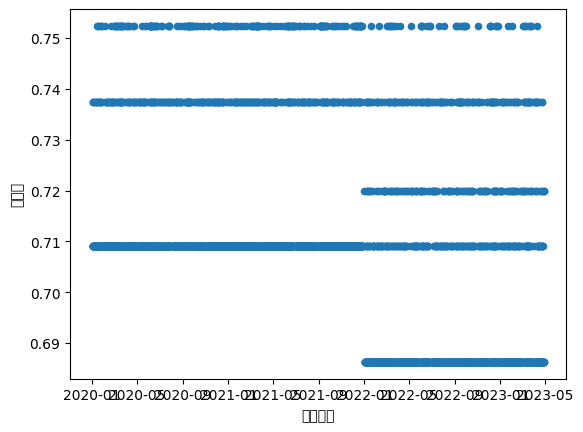

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


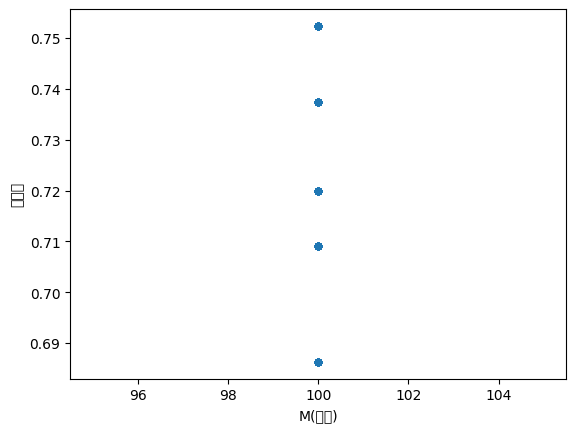

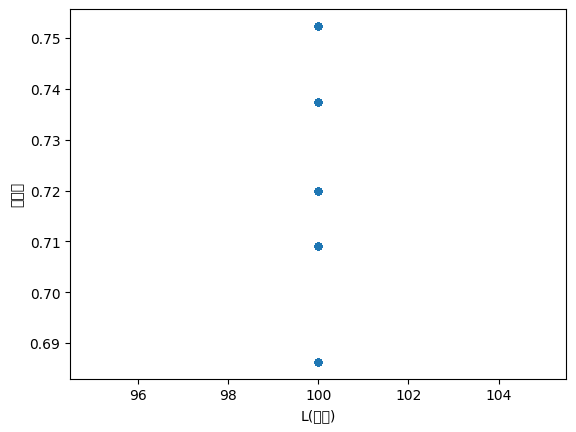

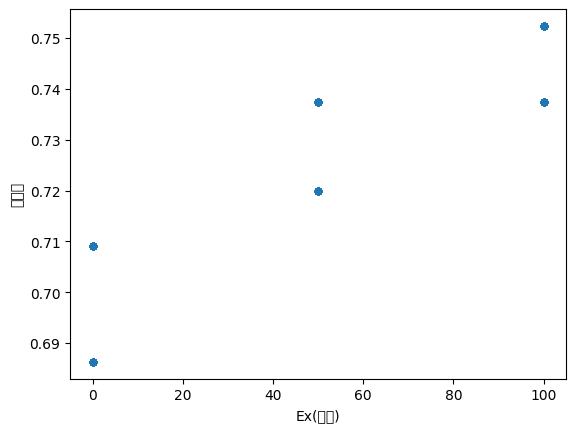

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21336 (\N{CJK UNIFIED IDEOGRAPH-5358}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


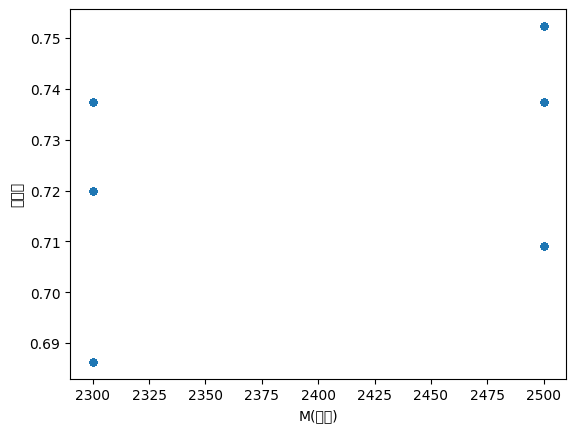

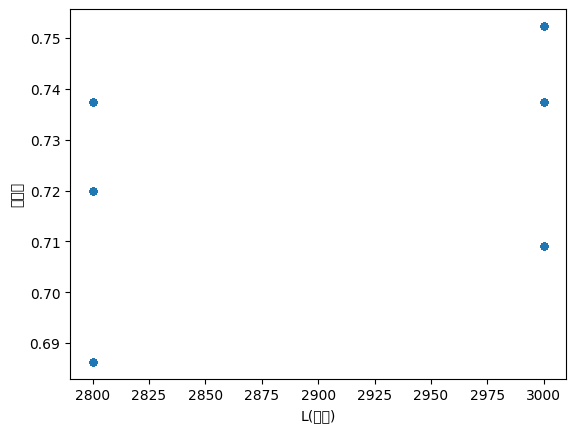

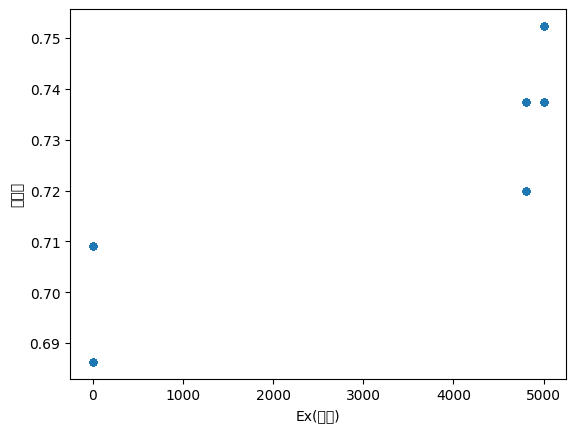

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35336 (\N{CJK UNIFIED IDEOGRAPH-8A08}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22770 (\N{CJK UNIFIED IDEOGRAPH-58F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-

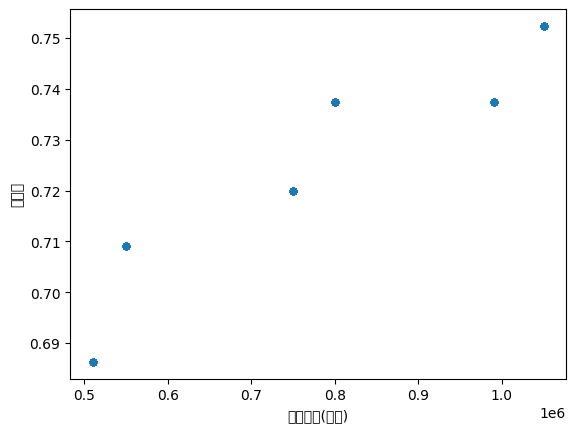

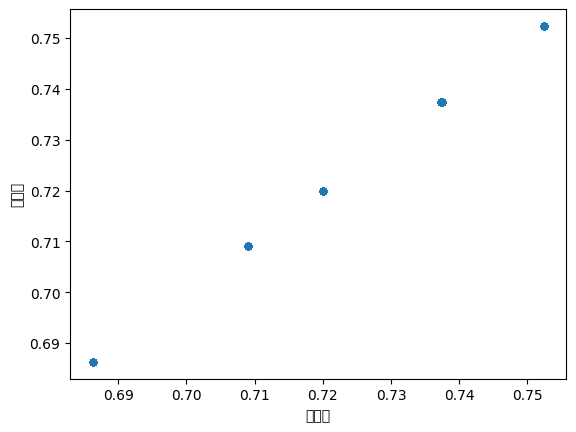

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packa

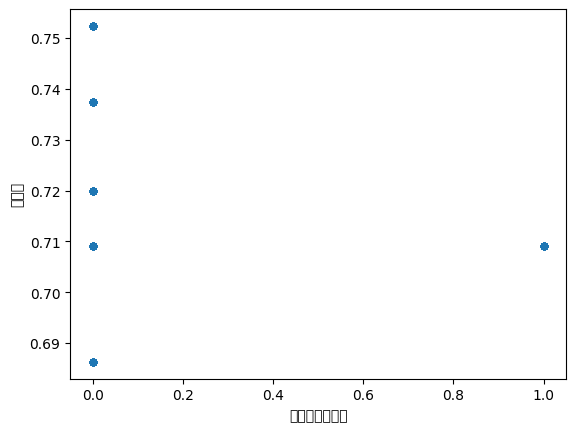

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


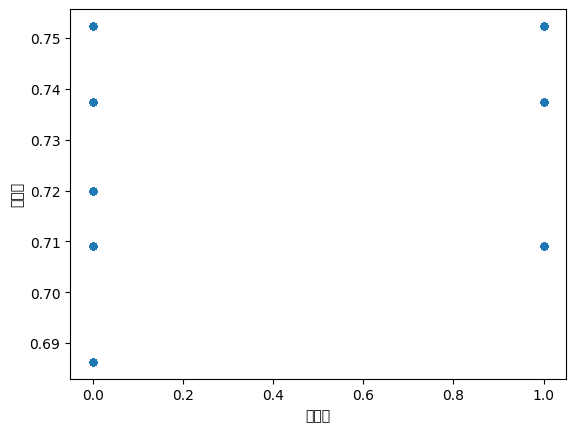

C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12484 (\N{KATAKANA LETTER TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12461 (\N{KATAKANA LETTER KI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-

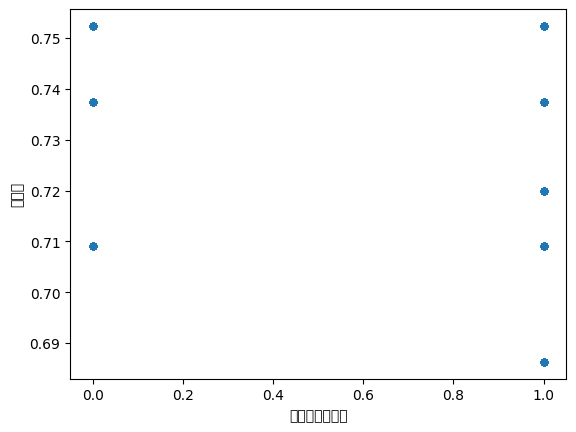

In [315]:
#散布図を確認（外れ値の確認）
for i in df1.columns:
  df1.plot(kind="scatter",x = i ,y = "収益性")

In [300]:
print("マツモトキヨシ全件数の収益性の平均値:", df1.query("マツモトキヨシ == 1")["収益性"].mean()) # ※全店舗の数ではなく、同じ店舗名重複の収益性の平均値。
print("イトーヨーカ堂全件数の収益性の平均値:", df1.query("イトーヨーカ堂 == 1")["収益性"].mean())
print("トモズ全件数の収益性の平均値:", df1.query("トモズ == 1")["収益性"].mean())
#df1.query("トモズ == 1")["収益性"]
#df1.query("トモズ == 1 and 収益性 > 0.7374")

マツモトキヨシ全件数の収益性の平均値: 0.706150606901943
イトーヨーカ堂全件数の収益性の平均値: 0.709090909090909
トモズ全件数の収益性の平均値: 0.7227851826536037


In [290]:
df1.query("収益性 > 0.71 and `Ex(数量)` == 50") #queryメソッドを使用する際、列名に特殊文字やスペースが含まれている場合、正しく機能しない。、バッククォートでEx(数量)を囲む。
df1.query("収益性 > 0.75 and トモズ == 1")

print("収益性の種類とその数",df1["収益性"].value_counts().sort_index())

#各系列店の収益性の種類とその数を表示。
print(df1.groupby("トモズ")["収益性"].value_counts()) #トモズ系列店では収益性が0.709091のデータが541件、0.737500のデータが240件、0.752381のデータが131件。
print(df1.groupby("マツモトキヨシ")["収益性"].value_counts()) #マツモトキヨシ系列店では収益性が0.686275のデータが1149件、0.709091のデータが1653件、、、。
print(df1.groupby("イトーヨーカ堂")["収益性"].value_counts()) #イトーヨーカ堂系列店では収益性が0.709091のみのデータで件数は93件。


収益性の種類とその数 収益性
0.686275    1149
0.709091    2287
0.720000     154
0.737374      85
0.737500     472
0.752381     259
Name: count, dtype: int64
トモズ  収益性     
0    0.709091    1746
     0.686275    1149
     0.737500     232
     0.720000     154
     0.752381     128
     0.737374      85
1    0.709091     541
     0.737500     240
     0.752381     131
Name: count, dtype: int64
マツモトキヨシ  収益性     
0        0.709091     634
         0.737500     240
         0.752381     131
1        0.709091    1653
         0.686275    1149
         0.737500     232
         0.720000     154
         0.752381     128
         0.737374      85
Name: count, dtype: int64
イトーヨーカ堂  収益性     
0        0.709091    2194
         0.686275    1149
         0.737500     472
         0.752381     259
         0.720000     154
         0.737374      85
1        0.709091      93
Name: count, dtype: int64


In [284]:
#収益性と各商品の販売個数の関係性

#収益性 = (売り上げ - 原価) / 売り上げ
#収益性 = {M(数量) * M(単価) + L(数量) * L(単価) + Ex(数量) *Ex(単価) }- {(M(数量) * 800 + L(数量) * 800 + Ex(数量) * 1000)} / {M(数量) * M(単価) + L(数量) * L(単価) + Ex(数量) *Ex(単価) }

print("収益性が0.686275のケース(全てﾏﾂﾓﾄｷﾖｼ) , M(数量): 100個(2300円) , L(数量) :100個(2800円) :",df1.query("収益性 < 0.686276 and `M(数量)`==100 and `L(数量)`==100 and `Ex(数量)` == 0 and `M(単価)`==2300 and `L(単価)`==2800").shape)

print("収益性が0.709091のケース , M(数量): 100個(2300円) , L(数量) :100個(2800円)  :" ,df1.query("収益性 < 0.709092 and 収益性 > 0.709090 and `M(数量)`== 100 and `L(数量)`== 100 and `Ex(数量)` == 0 and `M(単価)`==2500 and `L(単価)`==3000").shape) 

print("収益性が0.720000のケース , M(数量): 100個(2300円) , L(数量) :100個(2800円) ,Ex(数量):50個(4800円) :" , df1.query("収益性 == 0.72 and `M(数量)` == 100 and `L(数量)`==100 and `Ex(数量)` == 50 and `M(単価)`==2300 and `L(単価)`==2800 and `Ex(単価)` == 4800").shape)

print("収益性が0.737374のケース , M(数量): 100個(2300円) , L(数量) :100個(2800円) ,Ex(数量):100個(4800円) :" , df1.query("収益性 < 0.737375 and 収益性 > 0.737373 and `M(数量)` == 100 and `L(数量)`==100 and `Ex(数量)` == 100 and `M(単価)`==2300 and `L(単価)`==2800 and `Ex(単価)` == 4800").shape)

print("収益性が0.737500のケース , M(数量): 100個(2500円) , L(数量) :100個(3000円) ,Ex(数量):50個(5000円) :" , df1.query("収益性 < 0.7376 and 収益性 > 0.7374 and `M(数量)` == 100 and `L(数量)`==100 and `Ex(数量)` == 50 and `M(単価)`==2500 and `L(単価)`==3000 and `Ex(単価)` == 5000").shape)

print("収益性が0.752381のケース , M(数量): 100個(2500円) , L(数量) :100個(3000円) ,Ex(数量):100個(5000円) :" , df1.query("収益性 < 0.752382 and 収益性 > 0.752380 and `M(数量)` == 100 and `L(数量)`==100 and `Ex(数量)` == 100 and `M(単価)`==2500 and `L(単価)`==3000 and `Ex(単価)` == 5000").shape)



収益性が0.686275のケース(全てﾏﾂﾓﾄｷﾖｼ) , M(数量): 100個(2300円) , L(数量) :100個(2800円) : (1149, 12)
収益性が0.709091のケース , M(数量): 100個(2300円) , L(数量) :100個(2800円)  : (2287, 12)
収益性が0.720000のケース , M(数量): 100個(2300円) , L(数量) :100個(2800円) ,Ex(数量):50個(4800円) : (154, 12)
収益性が0.737374のケース , M(数量): 100個(2300円) , L(数量) :100個(2800円) ,Ex(数量):100個(4800円) : (85, 12)
収益性が0.737500のケース , M(数量): 100個(2500円) , L(数量) :100個(3000円) ,Ex(数量):50個(5000円) : (472, 12)
収益性が0.752381のケース , M(数量): 100個(2500円) , L(数量) :100個(3000円) ,Ex(数量):100個(5000円) : (259, 12)
